# GWAS for longevity and disease models 

## Initialize definitions

In [31]:
source(here::here("code/init.R"))
source(here::here("code/gwas.R"))
#options(gmax.data.size = 1e9)
options(tgutil.cache=FALSE)

### installing gwiser
This package is used for running gwas 


In [6]:
#remotes::install_github("tanaylab/gwiser")

In [7]:
library(gwiser) 

## Load scores 

See definition of all scores at `import` notebook, and at Netta's scripts. 

In [8]:
pop <- data.table::fread(here::here('output/pop_scores.csv')) %>% as_tibble()
head(pop %>% select(-id))

age,sex,longevity,longevity_q,diabetes,ckd,copd,cvd,liver
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
45,female,0.9675882,0.1925792,0.08815524,0.04167553,0.02798628,0.2060382,0.022592036
45,male,0.9119281,0.1060348,0.15909692,0.03919249,0.09064247,0.2944900,0.008487539
45,female,0.9969831,0.4574361,0.20979514,0.13855365,0.12811647,0.6370679,0.022256322
45,male,0.9945255,0.3984270,0.07791844,0.05965531,0.04335517,0.2117718,0.033393441
45,female,0.9838166,0.2651281,0.08008288,0.02218681,0.06593383,0.1207745,0.009952694
45,male,0.9377217,0.1345166,0.03196407,0.04930571,0.01263509,0.1157229,0.014305011


### Longevity

* We are removing patients with age above 75 years old (age != 80) due to small numbers
* When a patient appears twice (in multiple age groups), we are choosing the one closer to 60. 
* We are transforming the score to rank-based inverse normal (https://cran.r-project.org/web/packages/RNOmni/vignettes/RNOmni.html)

In [28]:
longevity_score <- pop %>% 
            select(id, sex, age, longevity) %>%        
            filter(age != 80) %>% 
            group_by(age, sex) %>% 
            mutate(score = RNOmni::RankNorm(longevity)) %>% 
            ungroup() %>% 
            arrange(abs(age - 60)) %>%  
            distinct(id, .keep_all=TRUE) %>% 
            as_tibble() %cache_df%
            here("output/longevity_score_inverse_rank.tsv") %>% 
            as_tibble()
head(longevity_score %>% select(-id))

sex,age,longevity,score
<chr>,<int>,<dbl>,<dbl>
female,60,0.9549366,-0.67789484
male,60,0.9999968,2.05605786
female,60,0.5790967,-2.22689019
female,60,0.9999069,1.44644466
female,60,0.9999707,1.74183198
male,60,0.9921567,0.02910422


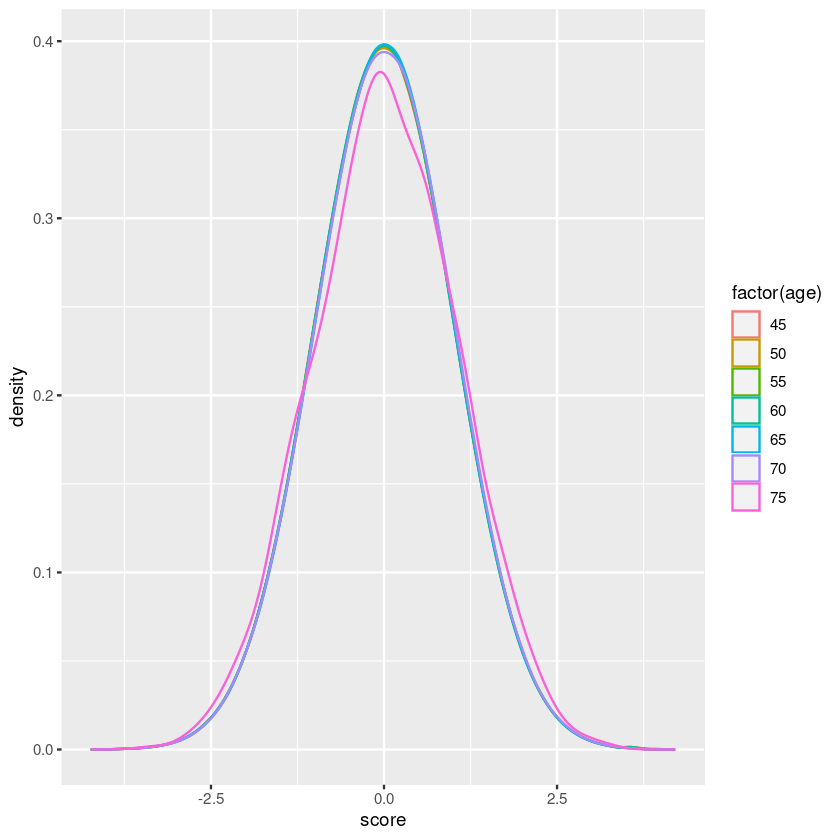

In [11]:
longevity_score %>% 
    ggplot(aes(x=score, color=factor(age))) + geom_density()

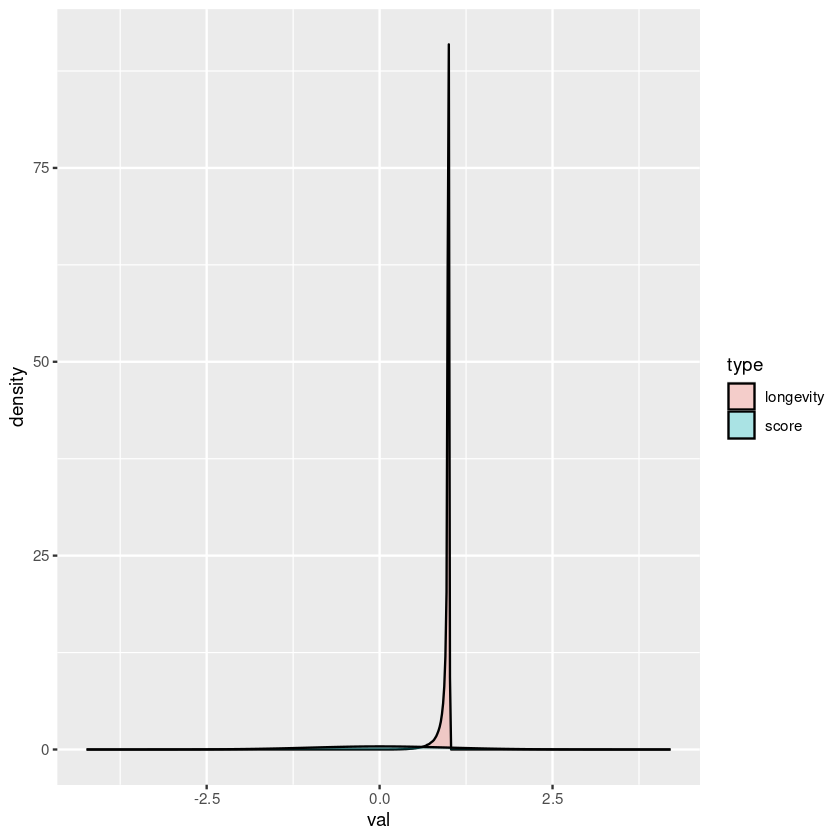

In [12]:
longevity_score %>%        
        gather("type", "val", -(id:age)) %>%
        ggplot(aes(x=val, fill = type)) + geom_density(alpha = 0.3)

### Disease score
Patients who are already sick get a score of 1.

In [13]:
disease_score <- pop %>%
            select(id:liver) %>% 
            pivot_longer(c("diabetes","ckd", "copd", "cvd", "liver"), names_to = "disease", values_to = "score") %>%                         filter(age != 80) %>% 
            arrange(abs(age - 60)) %>%  
            distinct(id, disease, .keep_all=TRUE) %>%            
            replace_na(replace = list(score = 1)) %>%  # Patients who are already sick get a score of 1   
            group_by(disease, age, sex) %>% 
            mutate(score_norm = RNOmni::RankNorm(score)) %>% 
            ungroup() %>%
            as_tibble() %cache_df%
            here("output/disease_score_inverse_rank.tsv") %>% 
            as_tibble()
            
head(disease_score %>% select(-id))

age,sex,longevity,longevity_q,disease,score,score_norm
<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
60,female,0.9549366,0.1554717,diabetes,0.28750988,-0.03568444
60,female,0.9549366,0.1554717,ckd,0.28626550,0.67358331
60,female,0.9549366,0.1554717,copd,0.10343341,0.41308296
60,female,0.9549366,0.1554717,cvd,0.66106439,0.31051869
60,female,0.9549366,0.1554717,liver,0.08393564,0.38211641
60,male,0.9999968,0.8883456,diabetes,1.00000000,1.76180221


## Run GWAS

In [14]:
library(bigsnpr)
library(bigreadr)
genes <- get_imputed_genes()

Loading preprocessed genetic data (imputed genotypes)



### Longevity

number of patients:

In [29]:
wb_patients <- fread(here("output/ukbb_white.british_patients.csv"))$id
sum(longevity_score$id %in% wb_patients & !is.na(longevity_score$score))

[1] 328542

In [16]:
head(longevity_score %>% select(-id))
longevity_score %>% filter(is.na(score)) %>% nrow()

sex,age,longevity,score
<chr>,<int>,<dbl>,<dbl>
female,60,0.9549366,-0.67789484
male,60,0.9999968,2.05605786
female,60,0.5790967,-2.22689019
female,60,0.9999069,1.44644466
female,60,0.9999707,1.74183198
male,60,0.9921567,0.02910422


[1] 0

In [17]:
gwas_longevity <- run_gwas_white_british(
    score_df = longevity_score %>% select(id, score), 
    covar = longevity_score %>% select(id, age, sex) %>% mutate(sex=as.numeric(factor(sex, levels=c('male', 'female')))), 
    genes = genes, ncores=70) %cache_rds% here("output/gwas_longevity_age_sex_covar_extended.rds")

i Loading precomputed PCA

Joining with `by = join_by(id)`
i seed: 60427

i using 327411 ids (out of 328542 in score_df and out of 486757 at the full genes object).

i Running GWAS (linear regression)

i Computing p-values

i Formatting result

v GWAS computed succesfully.



In [18]:
gwas_longevity_annot <- gwas_longevity %>%
        mutate(chrom = gsub("chr0", "chr", chrom)) %>% 
        arrange(pval) %cache_df% here("output/gwas_longevity_age_sex_covar_extended.tsv") %>% as_tibble()


### Longevity with disease confounders 

In [19]:
covar_df <- longevity_score %>% 
    select(id, age, sex) %>% 
    mutate(sex=as.numeric(factor(sex, levels=c('male', 'female')))) %>% 
    left_join(
        disease_score %>%
        select(id, age, disease, score_norm) %>% spread(disease, score_norm),
        by = c("id", "age")) %>% 
    as_tibble() %cache_df%
    here::here("output/disease_covariance.tsv") %>% 
    as_tibble()
head(covar_df)
stopifnot(all(longevity_score$id == covar_df$id))
#data.table::fwrite(covar_df, here::here("output/disease_covariance.csv"))

id,age,sex,ckd,copd,cvd,diabetes,liver
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000019,60,2,0.6735833,0.4130830,0.3105187,-0.03568444,0.3821164
1000035,60,1,1.1376099,1.5829298,1.6208614,1.76180221,0.6772193
1000078,60,2,-0.7250093,-0.2529133,-0.3637774,-0.26826177,-0.7730427
1000081,60,2,0.1751377,0.7137014,1.2381123,1.02198105,2.0536824
1000287,60,2,1.3299205,1.8791902,1.2179476,1.19609653,0.8294608
1000357,60,1,-0.1867358,-0.4803372,0.2739957,0.90762588,0.9107958


In [20]:
bigparallelr::nb_cores()

[1] 1

In [21]:
gwas_longevity_disease_covar <- run_gwas_white_british(
    score_df = longevity_score %>% select(id, score), 
    covar = covar_df, 
    genes = genes, ncores=70) %cache_rds% here("output/gwas_longevity_age_sex_disease_covar_extended.rds")

i Loading precomputed PCA

Joining with `by = join_by(id)`
i seed: 60427

i using 327411 ids (out of 328542 in score_df and out of 486757 at the full genes object).

i Running GWAS (linear regression)

i Computing p-values

i Formatting result

v GWAS computed succesfully.



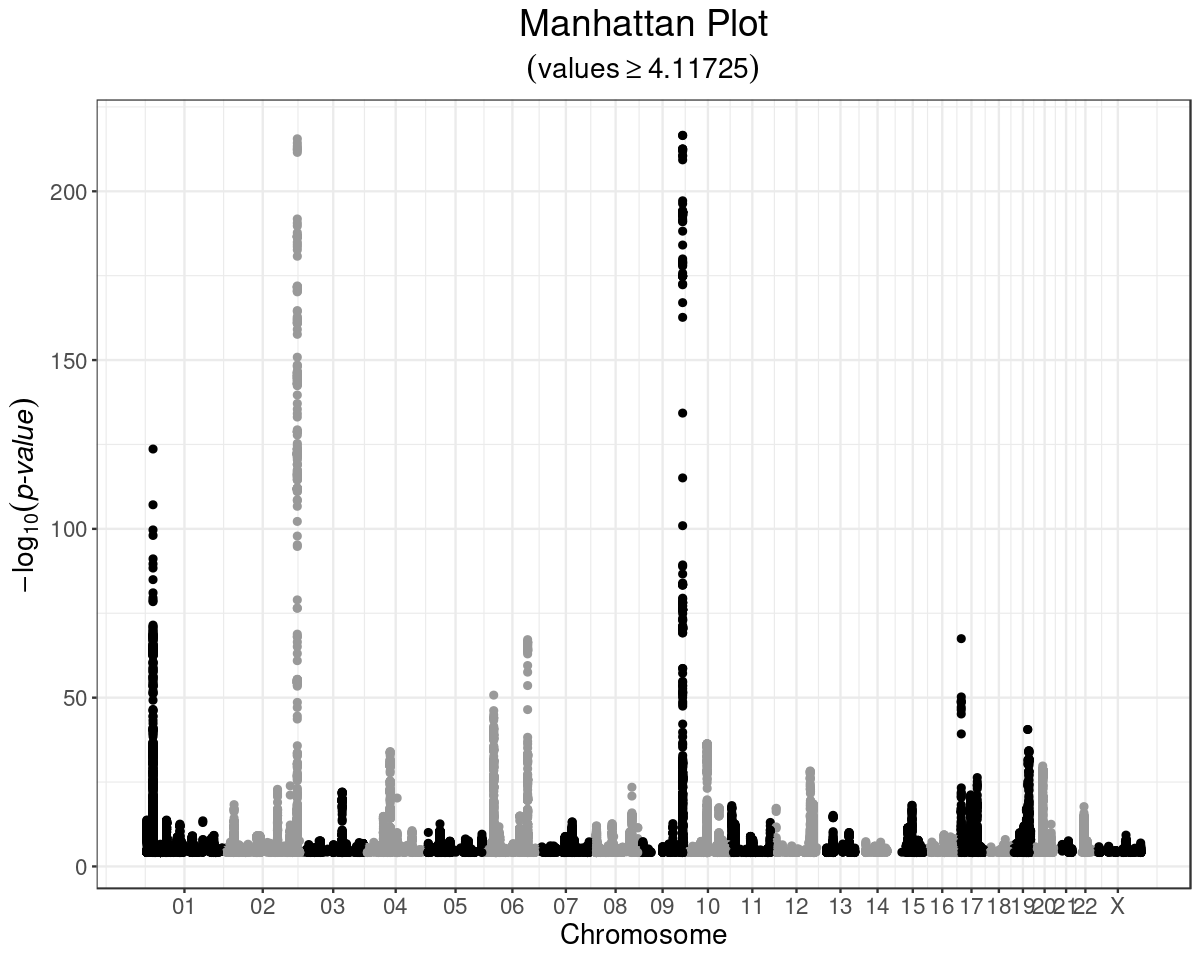

In [22]:
options(repr.plot.width = 10, repr.plot.height = 8)
bigsnpr::snp_manhattan(gwas_longevity_disease_covar, genes$map$chromosome, genes$map$physical.pos, npoints = 50e3, coeff = 1)

Warning message:
"Removed 4852 rows containing missing values (`geom_point()`)."


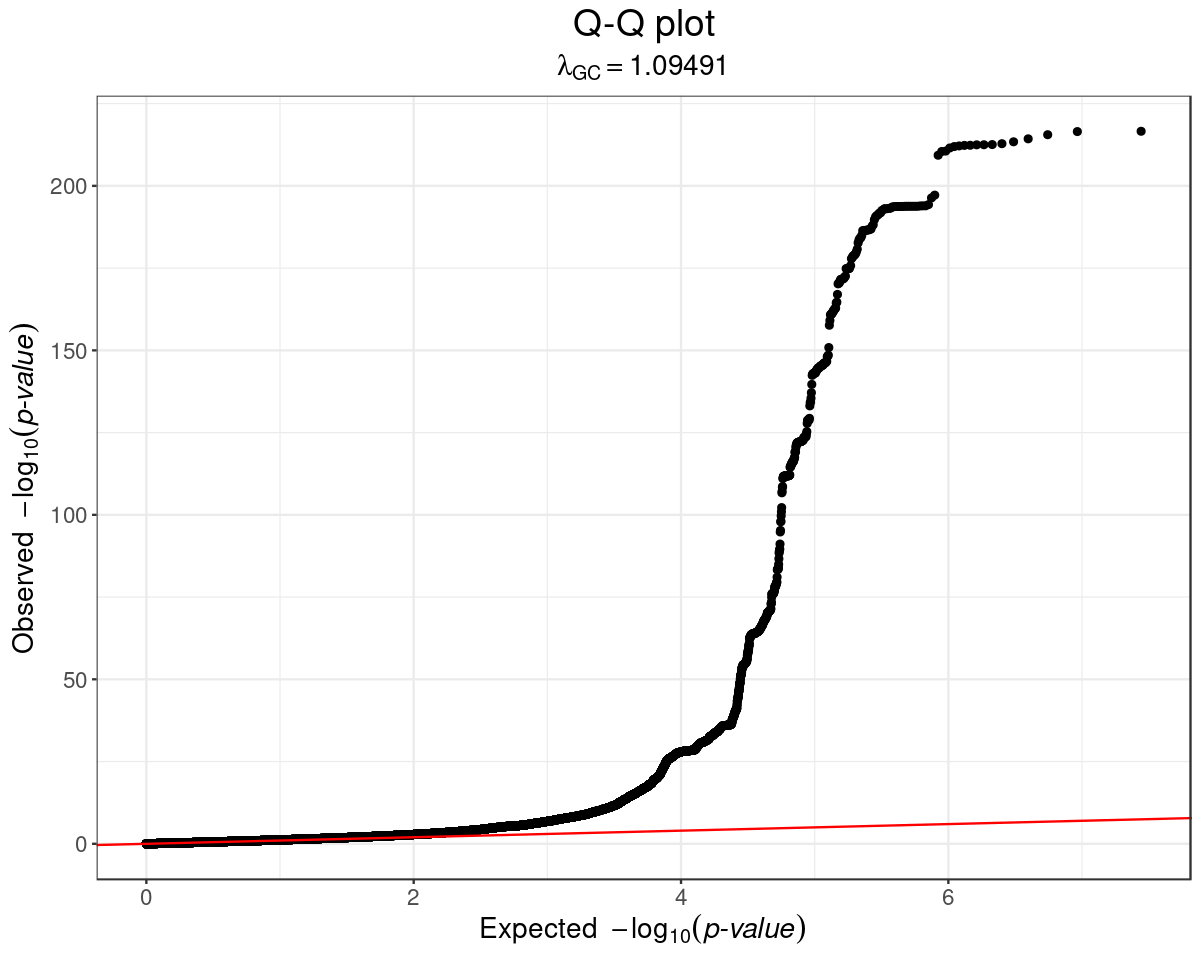

In [23]:
options(repr.plot.width = 10, repr.plot.height = 8)
bigsnpr::snp_qq(gwas_longevity_disease_covar)

In [24]:
gwas_longevity_disease_covar_annot <- gwas_longevity_disease_covar %>%
        mutate(chrom = gsub("chr0", "chr", chrom)) %>% 
        arrange(pval) %cache_df% here("output/gwas_longevity_age_sex_disease_covar_extended.tsv") %>% as_tibble()

### Diseases

In [25]:
diseases <- unique(disease_score$disease)
diseases

[1] "diabetes" "ckd"      "copd"     "cvd"      "liver"

In [26]:
library(glue)
walk(diseases, ~ {
    cli_alert_info(.x)    
    df <- disease_score %>%                            
          filter(disease == .x) %>% 
          select(-sex) %>% 
          left_join(genes$fam %>% select(id = sample.ID, sex)) %>% 
          select(id, age, score = score_norm, sex)
    res <- run_gwas_white_british(
        score_df = df %>% select(id, score), 
        covar = df %>% select(id, age, sex), 
        genes = genes, ncores=70) %cache_rds% here(glue("output/gwas_{.x}_age_sex_covar_extended.rds"))
    res %>%
        mutate(chrom = gsub("chr0", "chr", chrom)) %>% 
        arrange(pval) %cache_df% here(glue("output/gwas_{.x}_age_sex_covar_extended.tsv")) %>% as_tibble() 
    gc()
})

i diabetes

Joining with `by = join_by(id)`
i Loading precomputed PCA

Joining with `by = join_by(id)`
i seed: 60427

i using 327411 ids (out of 328542 in score_df and out of 486757 at the full genes object).

i Running GWAS (linear regression)

i Computing p-values

i Formatting result

v GWAS computed succesfully.

i ckd

Joining with `by = join_by(id)`
i Loading precomputed PCA

Joining with `by = join_by(id)`
i seed: 60427

i using 327411 ids (out of 328542 in score_df and out of 486757 at the full genes object).

i Running GWAS (linear regression)

i Computing p-values

i Formatting result

v GWAS computed succesfully.

i copd

Joining with `by = join_by(id)`
i Loading precomputed PCA

Joining with `by = join_by(id)`
i seed: 60427

i using 327411 ids (out of 328542 in score_df and out of 486757 at the full genes object).

i Running GWAS (linear regression)

i Computing p-values

i Formatting result

v GWAS computed succesfully.

i cvd

Joining with `by = join_by(id)`
i Loading pre

In [27]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,29340548,1567.0,59601695,3183.1,44553990,2379.5
Vcells,766272040,5846.2,1440848050,10992.8,1434414827,10943.8


## H^2 SNP
Create ldsc format sumstats:

In [32]:
pvals <- get_gwas_pvals() %cache_df% here("output/all_pvals.tsv") %>% as_tibble()

Joining with `by = join_by(rsid, allele1, allele2)`
Joining with `by = join_by(rsid, allele1, allele2)`
Joining with `by = join_by(rsid, allele1, allele2)`
Joining with `by = join_by(rsid, allele1, allele2)`
Joining with `by = join_by(rsid, allele1, allele2)`
Joining with `by = join_by(rsid, allele1, allele2)`


adding std.err column from gwas of longevity with disease as covariance

In [ ]:
gwas_longevity_disease_covar <- readr::read_rds(here("output/gwas_longevity_age_sex_disease_covar.rds"))

In [ ]:
pvals <- pvals %>% left_join(gwas_longevity_disease_covar %>% select(marker.ID, allele1, allele2, std.err))

In [ ]:
pvals %>%
        filter(chrom != "chrX") %>% 
        mutate(N = 328542, CHR = gsub("chr", "", chrom),  Z = longevity_disease_covar_beta / std.err) %>%
        select(CHR, BP = start, A1 = allele1, A2 = allele2, N, Z, P = longevity_disease_covar_pval, SNP = rsid) %>%
        fwrite(here("output/longevity_snps_ldsc.sumstats"), sep = " ", quote = FALSE)

at the terminal (polyfun conda):

./ldsc.py \
--out /home/aviezerl/proj/ukbb/output/longevity_snps_ldsc.h2 \
--h2 /home/aviezerl/proj/ukbb/output/longevity_snps_ldsc.sumstats \
--ref-ld-chr baselineLF2.2.UKB/baselineLF2.2.UKB. \
--w-ld-chr baselineLF2.2.UKB/weights.UKB. \
--not-M-5-50
Total Observed scale h2: 0.0637 (0.0084)